# Unbinned likelihood fit example
Author: Aleksander Filip Żarnecki (University of Warsaw)

### (0) Import libraries 

In [1]:
import math
from ROOT import *
import numpy as np
from array import array

# For inline image display
from IPython.display import Image

Welcome to JupyROOT 6.24/04


### (1) ROOT settings

In [2]:
# Set ROOT graphics options

gROOT.SetStyle("Plain")

# Default canvas  size

gStyle.SetCanvasDefW(600)
gStyle.SetCanvasDefH(400)
 
# set the margins
  
gStyle.SetPadBottomMargin(0.18)
gStyle.SetPadTopMargin(0.08)
gStyle.SetPadRightMargin(0.08)
gStyle.SetPadLeftMargin(0.17)

# set the number of divisions to show

gStyle.SetNdivisions(510, "xy")

# show grid

gStyle.SetPadGridX(1)
gStyle.SetPadGridY(1)

# border ploted only around statistics

gStyle.SetPadBorderMode(0)
gStyle.SetFrameBorderMode(0)
gStyle.SetLegendBorderSize(0)
gStyle.SetTitleBorderSize(0)
gStyle.SetStatBorderSize(1)

# Text sizes

gStyle.SetTextSize(0.05)
gStyle.SetTitleSize(0.06,"xyz")
gStyle.SetLabelSize(0.05,"xyz")

gStyle.SetLabelOffset(0.015,"xyz")
gStyle.SetTitleOffset(1.2,"yz")
gStyle.SetTitleOffset(1.0,"x")

# Font settings

font = 42
gStyle.SetTitleFont(font)
gStyle.SetTitleFontSize(0.05)
gStyle.SetStatFont(font)
gStyle.SetStatFontSize(0.06)
gStyle.SetTextFont(font)
gStyle.SetLabelFont(font,"xyz")
gStyle.SetTitleFont(font,"xyz")
gStyle.SetLegendFont(font)

# Line settings

gStyle.SetHistLineWidth(2)
gStyle.SetFrameLineWidth(2)
gStyle.SetFuncWidth(2)
gStyle.SetHistLineColor(kBlue)
gStyle.SetFuncColor(kRed)

# Log scale
gStyle.SetOptLogy(0)

# Histogram title
gStyle.SetOptTitle(1)  

# Histogram statistics
# gStyle.SetOptStat(1100)
gStyle.SetOptStat(0)

# Fit results
gStyle.SetOptFit(0) 


### (2) Define fit model

In [3]:
tmax = 100

# Exponential decay + uniform background

def myfun(x,par):

    # decay time
    
    tdec = par[0]
    
    # Decay fraction
    
    fdec = par[1]

    # Exponential probability distribution
    
    val = fdec/tdec * np.exp(-x/tdec)

    # Add constant term
    
    val += (1-fdec)* 1./tmax

    return val

# Full model: returns values and derivatives

def myfunder(x,par):

    # output arrays
    
    val = np.zeros(x.size)
    der = np.zeros((x.size,2))

    # decay time
    
    tdec = par[0]
    
    # Decay fraction
    
    fdec = par[1]

    # Exponential probability distribution
    
    val = 1/tdec * np.exp(-x/tdec)

    der[:,0] = val*(x-tdec)/tdec/tdec
    
    # Take background fraction into account
    
    der[:0] *= fdec
    
    der[:,1] = val - 1./tmax
    
    val = fdec*val + (1-fdec)* 1./tmax

    return val,der


### (3) Read input data

In [23]:
# Read background fit output

Nevt = 100
infile = "10_example_data_"+str(Nevt)+".dat"

xvec = np.fromfile(infile,sep=' ')

In [50]:
# Create  histogram for display

tmax = 100.
Nbin = 100

hgen = TH1D('hgen','Distribution of generated decay times',Nbin,0.,tmax)

# Fill histogram

for ievt in range(Nevt):
    hgen.Fill(xvec[ievt])
    

### (4) Iterative fit

In [51]:
# Number of function parameters to consider  (fixed for this model)

Nfun = 2

# Initial guess for parameters

parini = np.zeros(Nfun)
parini[0] = 2.
parini[1] = 0.99

# Initial function vales

# fini,dini = myfunder(xvec,parini) 
fini = myfun(xvec,parini) 

# Initial printout

loglini = np.sum(np.log(fini))

print("\nIterative fit procedure starting from parameter values")
print(" ",parini)
print("  LL =  %8.3f   LL/N = %8.5f " % (loglini,loglini/xvec.size))


Iterative fit procedure starting from parameter values
  [2.   0.99]
  LL =  -323.821   LL/N = -3.23821 


In [52]:
# Main loop

lam = 0.01       # Low value -> jump close to minimum, high value -> smaller step along gradient

dcut = 0.001   # Required precision (distance from minimum)

loglmin = loglini
parmin = parini

par = parini

parhist = []
parhist.append(par)

Nit = 0

Cov = np.zeros((Nfun,Nfun))

dist = dcut+1

while dist > dcut :

    # work space
    
    A = np.zeros((Nfun,Nfun))
    B = np.zeros(Nfun)

    # Values and derivatives at the current point
    
    fval,fder = myfunder(xvec,par)
    
    for l in range(Nfun):
        B[l] = np.sum(fder[:,l]/fval)
        for k in range(Nfun):
            A[l,k] = np.sum(fder[:,l]*fder[:,k]/fval/fval)

    # Do not try to jump directly to the maximum (lam = 0)

    C = A
    for l in range(Nfun):
#        C[l,l] *= 1 + lam
        C[l,l] += lam
        
    # Inverse of matrix

    Cinv = np.linalg.inv(C)

    # Solution to the problem - required parameter change

    dpar = Cinv @ B

    # Check new parameter values
    
    parnew = par+dpar

    fnew = myfun(xvec,parnew) 

    loglnew = np.sum(np.log(fnew))

    # Distance to minimum (assuming current errors)

    Cov = np.linalg.inv(A)
    e2par = np.diagonal(Cov)
    dist = np.sum(dpar*dpar/e2par)
    
    Nit+=1
    print("\nIteration step ",Nit," with lambda = ",lam)
    print(" ",parnew)
    print("  LL =  %8.3f   LL = %8.5f " % (loglnew,loglnew/(xvec.size-Nfun)))
    print("  distance to minimum: ",dist)
    
    if loglnew > loglmin :
        lam /= 10
        loglmin = loglnew
        par = parnew
    else:
        lam *= 10

    parhist.append(par)


Iteration step  1  with lambda =  0.01
  [2.20652822 0.98035806]
  LL =  -310.964   LL = -3.17310 
  distance to minimum:  18.256760017154143

Iteration step  2  with lambda =  0.001
  [2.27697261 0.96200322]
  LL =  -299.852   LL = -3.05971 
  distance to minimum:  16.055809095213057

Iteration step  3  with lambda =  0.0001
  [2.25641675 0.92926082]
  LL =  -290.576   LL = -2.96506 
  distance to minimum:  13.733304978656628

Iteration step  4  with lambda =  1e-05
  [2.2097543  0.87854167]
  LL =  -284.214   LL = -2.90014 
  distance to minimum:  9.781356684965749

Iteration step  5  with lambda =  1.0000000000000002e-06
  [2.16209    0.82068906]
  LL =  -281.461   LL = -2.87206 
  distance to minimum:  4.5619373663437885

Iteration step  6  with lambda =  1.0000000000000002e-07
  [2.13223718 0.78624113]
  LL =  -281.023   LL = -2.86758 
  distance to minimum:  0.8202896476635467

Iteration step  7  with lambda =  1.0000000000000002e-08
  [2.12371085 0.78020073]
  LL =  -281.013   

In [53]:
# Parameter uncertainties 
# (assuming no need to recalculate Cov, even if there was a slight improvement in the last step)

epar = np.sqrt(np.diagonal(Cov))

print("\n Fit results:\n\n     par         sigma_p\n")

for ip in range(par.size):
    print("  %8.3f  +/- %6.3f " % (par[ip],epar[ip]))

# Calculate correlation matrix, including rounding

Corr = Cov

print("\n Correlation matrix\n")
for ip in range(par.size):
    for jp in range(par.size):
        Corr[ip,jp]=int(1000.*Corr[ip,jp]/epar[ip]/epar[jp]+0.5)/1000.
        
    print(Corr[ip,:])

# Fitted function

fvec = myfun(xvec,par) 

# Chi^2 printout

logl = np.sum(np.log(fvec))

print("\n LL =  %8.3f   LL/Ndf = %8.5f " % (logl,logl/(xvec.size-Nfun)))

# print("\n  x       y         f(x) ")
# for ix in range(xvec.size):
#     print("%6.3f  %8.5f  %8.5f " % (xvec[ix],yvec[ix],fvec[ix]))


 Fit results:

     par         sigma_p

     2.122  +/-  0.218 
     0.780  +/-  0.045 

 Correlation matrix

[1.    0.148]
[0.148 1.   ]

 LL =  -281.013   LL/Ndf = -2.86748 


### (6) Draw data and fit

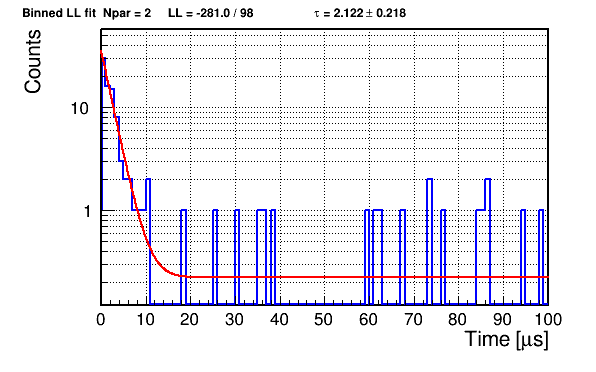

Warning in <TCanvas::Constructor>: Deleting canvas with same name: cexp2
Info in <TCanvas::Print>: png file 10_unbinned_fit_100_100.png has been created


In [55]:
# Lin scale

gStyle.SetOptLogy(1)

# Create plot canvas

# gStyle.SetCanvasDefH(600)  # Default is 600 x 400

cexp2 = TCanvas('cexp2')
   
## Histogram

hgen.SetNameTitle('dgr','Binned LL fit  Npar = '+str(Nfun)+'     LL = '+str(int(100*logl+0.5)/100.)+' / '+str(xvec.size-Nfun)
                + '                    #tau = '+str(int(1000.*par[0]+0.5)/1000.)+' #pm '+str(int(1000.*epar[0]+0.5)/1000.))

hgen.GetXaxis().SetTitle("Time [#mus]")
hgen.GetYaxis().SetTitle("Counts")
hgen.SetLineColor(4)
hgen.SetLineWidth(2)
hgen.SetLineStyle(1)
hgen.SetMinimum(0.12)   
hgen.Draw()

# Fitted dependence wraper for root

def myfit(x, fpar):
    
    xv = np.array([x[0]])
   
    val = myfun(xv,par)
        
    return Nevt*tmax/Nbin*val

# Define user function

fexp=TF1("fexp",myfit,0,tmax,Nfun)

for ip in range(Nfun):
    fexp.SetParameter(ip,par[ip])
    
fexp.SetNpx(1000)
fexp.SetLineStyle(1)
fexp.SetLineColor(2)

# Do not draw function for Nfun=1

fexp.DrawCopy("Lsame")

cexp2.Update()
fname = '10_unbinned_fit_'+str(Nevt)+'_'+str(Nbin)+'.png'
cexp2.Print(fname)

Image(filename=fname)